['JD', 'Magnitude', 'Uncertainty', 'HQuncertainty', 'Band', 'Observer Code', 'Comment Code(s)', 'Comp Star 1', 'Comp Star 2', 'Charts', 'Comments', 'Transfomed', 'Airmass', 'Validation Flag', 'Cmag', 'Kmag', 'HJD', 'Star Name', 'Observer Affiliation', 'Measurement Method', 'Grouping Method', 'ADS Reference', 'Digitizer', 'Credit']


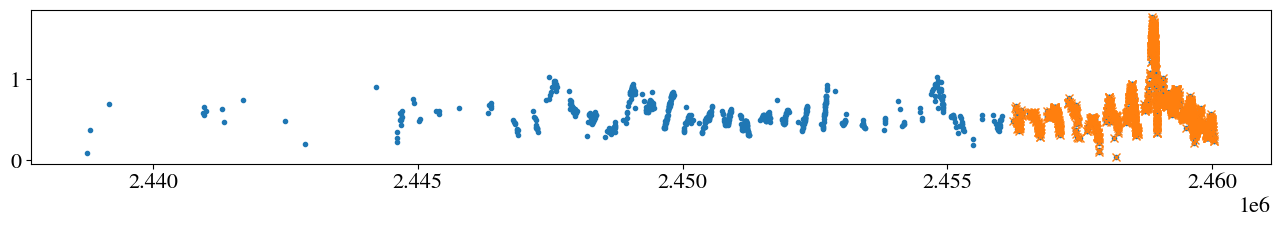

In [2]:
#
# chuang 
# 04.07.2023
#
"""Plot up the RV and the lightcurve data on the same plot"""
import numpy as np 
import matplotlib.pyplot as plt 
import astropy.units as u
from astropy.io import ascii
from scipy.signal import argrelextrema

# I should probably sort the data by the date of observation 
from astropy.modeling.fitting import (SplineInterpolateFitter,
                                      SplineSmoothingFitter,
                                      SplineExactKnotsFitter)
from astropy.convolution import convolve, Box1DKernel,Gaussian1DKernel

from astropy.modeling import models, fitting
from scipy.interpolate import UnivariateSpline

plt.ion()

plt.rcParams['figure.figsize'] = (6,5)
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 16

# AAVSO data 
#daavso = ascii.read("aavsodata_636b01e2a6fd5.txt") # older AAVSO file
daavso = ascii.read("aavsodata_643217704ea90.txt") # new AAVSO file
# removed a bunch of measurements that had photometry given as <1.6 
daavso.sort('JD')
print(daavso.keys())
daavso['Magnitude']=daavso['Magnitude'].astype(float)

selVisV = (daavso['Band']=='Vis.') | (daavso['Band']=='V') 

plt.figure(figsize=(16,2))
selV =  (daavso['Band']=='V') 
plt.plot(daavso[selV]['JD'],daavso[selV]['Magnitude'],'.')
selVdate = selV & (daavso['JD']>2.4562e6)
#selVdate = selV & (daavso['JD']>2.454754e6)
plt.plot(daavso[selVdate]['JD'],daavso[selVdate]['Magnitude'],'x')

# Photometric Data

Text(0, 0.5, 'V Mag')

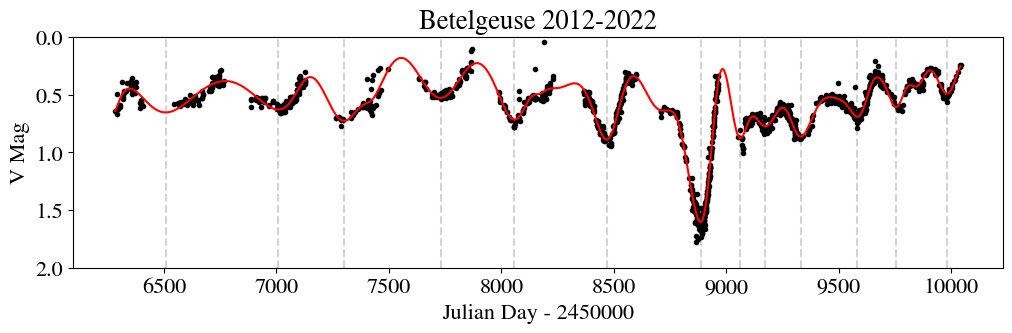

In [3]:
das = daavso[selVdate]
#das.sort('JD')
ta = das['JD']-2450000
ya = das['Magnitude']
nonrepeating = (ta[1:]-ta[0:-1]>0)
ta = ta[1:][nonrepeating].copy() * u.d
ya = ya[1:][nonrepeating].copy() * u.mag


plt.figure(figsize=(12,3))
plt.plot(ta,ya,'k.')

#spl = models.Spline1D()
#fitter = fitting.SplineInterpolateFitter()
#splall = fitter(spl,ta,ya, s=45, degree=2)

splphot = UnivariateSpline(ta, ya, s=3, k=5)

days_phot = np.linspace(np.min(ta), np.max(ta), int((np.max(ta)-np.min(ta)).value) )
smoothed_signal_phot = convolve(splphot(days_phot), Box1DKernel(30), boundary="extend") # 30 d smoothing
t_photminima = days_phot[ argrelextrema(splphot(days_phot),np.greater, order=60)]

#plt.plot(ta,spl(ta),'-',alpha=0.6,zorder=99,color='Red')
plt.plot(days_phot, smoothed_signal_phot, color="red")
#plt.plot(days, spl(days), color="blue")

for tm in t_photminima:
    plt.axvline(tm.value,linestyle='--',color='LightGrey',zorder=0)
    
plt.ylim(2,0)
plt.title("Betelgeuse 2012-2022")
plt.xlabel('Julian Day - 2450000')
plt.ylabel('V Mag')
#plt.savefig('figs/lc_2012-2022.pdf',bbox_inches='tight')

# Radial Velocity Data

<Figure size 600x500 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

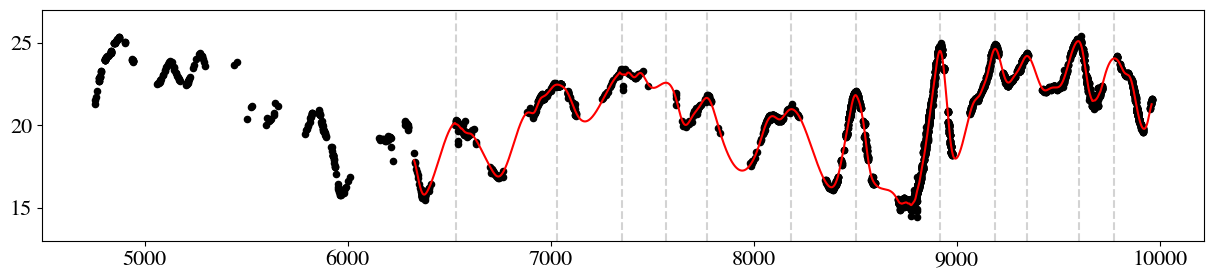

In [4]:
RVfile = 'sorted_RV.dat'
catdat = np.genfromtxt(RVfile, dtype=[('JD', 'f8'), ('V', 'f8'), ('e', 'f8')], usecols=(0, 1, 2))
origJD = catdat['JD']
origV = catdat['V']*u.mag
orige = catdat['e']

subJD = (origJD - 2450000)*u.d

# resample to linear with some kind of smoothing -- whatever you can get to work best
# then apply convolution spl = models.Spline1D()
spl = UnivariateSpline(subJD, origV, s=43) # 43 seems to be the minimum to get rid of any huge spikes 
#print(subJD)
#print(splall(subJD))
plt.clf()
plt.figure(figsize=(15, 3))

gd = np.where(subJD.value > 6300)[0]
days = np.linspace(np.min(subJD[gd]), np.max(subJD), int((np.max(subJD)-np.min(subJD[gd]) ).value) ) # 1 d spacing
smoothed_signal = convolve(spl(days), Box1DKernel(30), boundary="extend") # smooth on 30d width
t_rvminima = days[ argrelextrema(spl(days),np.greater, order=60)]  # consider X d in maxima

plt.clf()
plt.figure(figsize=(15, 3))
plt.ylim([13, 27])

#plt.plot(days,spl(days))
plt.plot(days, smoothed_signal, color="red",ls='-')
plt.scatter(subJD, origV, color="black", s=20)


for tm in t_rvminima:
    plt.axvline(tm.value, linestyle='--',color='LightGrey',zorder=0)

# Both Together

<Figure size 600x500 with 0 Axes>

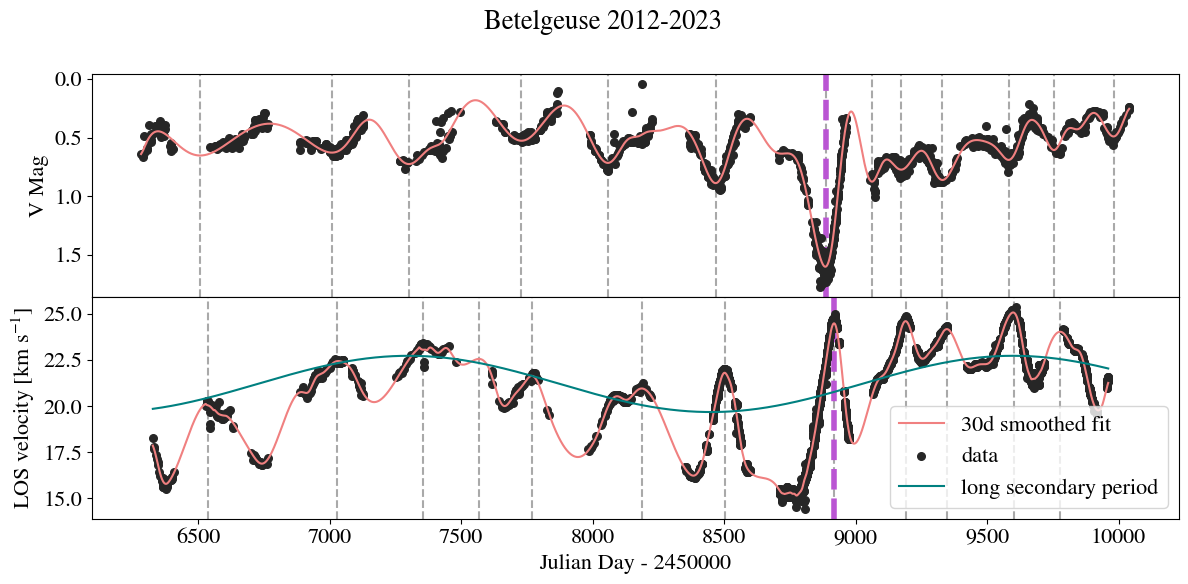

In [9]:
plt.clf()
fig, axs = plt.subplots(2, figsize=(12,6), sharex=True)
fig.suptitle('Betelgeuse 2012-2023')

def plot_fit(A, B, mean, per, t):
	"""I believe the fit function is Acos(wt) + Bsin(wt) + meanmag, where 
	w = 2 * np.pi / period"""
	w = 2*np.pi/per
	return A*np.cos(w*t) + B*np.sin(w*t) + mean

# fit parameters to the LSP (from chi-square minimization of a sine fit over a period grid of 2100-2500 d -- the 
# range of literature values cited for the LSP)
# can include the fitting minimization program too, but I did that separately 
A = 0.6796077918439476
B = 1.3671488895507102
mag_mean = 21.206580225950713
Amp = 3.0534982147921728
pfind = 2298.1614708233355

xs = np.linspace(np.min(subJD.value[gd]), np.max(subJD.value), 10000)
ys = plot_fit(A, B, mag_mean, pfind, xs)

# RV
axs[1].plot(days, smoothed_signal, color="LightCoral",label='30d smoothed fit')
axs[1].scatter(subJD[gd], origV[gd], color="0.15", s=30,rasterized=True,label='data')
for tm in t_rvminima:
    axs[1].axvline(tm.value, linestyle='--',color='DarkGrey',zorder=0)

axs[1].axvline(t_rvminima[7].value, linestyle='--',color='mediumorchid',zorder=0,lw=4)

axs[1].plot(xs, ys, color="Teal",label='long secondary period')
axs[1].set_ylabel("LOS velocity [km s$^{-1}$]")
plt.legend()

# lightcurve
axs[0].scatter(ta,ya, color="0.15", s=30,rasterized=True)
axs[0].set_ylabel("V Mag")
axs[0].invert_yaxis()
axs[0].plot(days_phot, smoothed_signal_phot, color="LightCoral")

for tm in t_photminima:
    axs[0].axvline(tm.value,linestyle='--',color='DarkGrey',zorder=0)
    
axs[0].axvline(t_photminima[6].value, linestyle='--',color='mediumorchid',zorder=0,lw=4)

plt.xlabel("Julian Day - 2450000")
plt.tight_layout()
plt.subplots_adjust(hspace=0.0)
plt.savefig("figs/Betelgeuse_RV_lc.pdf",bbox_inches='tight',dpi=150)

# Histogram Time

[176.08807029 111.05554433 157.0785627  252.12610064 172.08606869
 227.11359065] d
[501.25070008 292.14611661 428.21417093 328.16413099 410.20516374
 418.20916693] d


Text(0.5, 1.0, 'Betelgeuse 2012-2023')

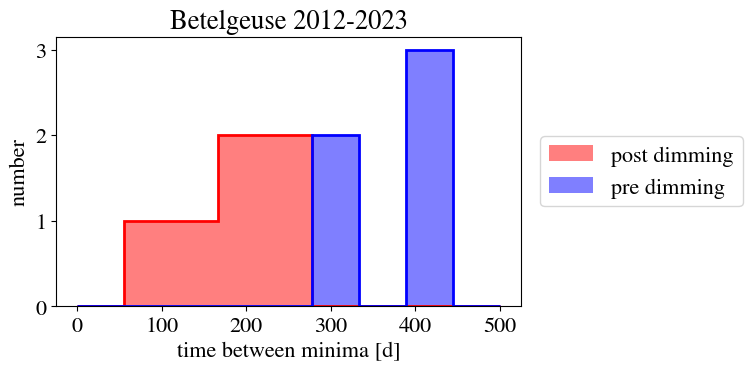

In [10]:
dt_minima = t_photminima[1:]-t_photminima[0:-1]
dt_minima_post = t_photminima[t_photminima>(2.4588e6-2.45e6)*u.d][1:]- t_photminima[t_photminima>(2.4588e6-2.45e6)*u.d][0:-1]
dt_minima_pre = t_photminima[t_photminima<(2.459e6-2.45e6)*u.d][1:]- t_photminima[t_photminima<(2.459e6-2.45e6)*u.d][0:-1]
print(dt_minima_post)
print(dt_minima_pre)

plt.figure(figsize=(6,3.5))
nbins = 10
#plt.hist(dt_minima.value,bins=np.linspace(0,500,nbins),color='0.7',label='all',rasterized=True)
plt.hist(dt_minima_post.value,bins=np.linspace(0,500,nbins),histtype='step',color="red",lw=2)
plt.hist(dt_minima_pre.value,bins=np.linspace(0,500,nbins),histtype='step',color="Blue",lw=2)
plt.hist(dt_minima_post.value,bins=np.linspace(0,500,nbins),histtype='stepfilled',label='post dimming',alpha=0.5,color="red")
plt.hist(dt_minima_pre.value,bins=np.linspace(0,500,nbins),histtype='stepfilled',label='pre dimming',alpha=0.5,color="blue")
#plt.hist(dt_minima_post.value,bins=np.linspace(0,500,nbins),histtype='step',label='post dimming',alpha=0.7,lw=3,ls='--',hatch='/')
#plt.hist(dt_minima_pre.value,bins=np.linspace(0,500,nbins),histtype='step',label='pre dimming',alpha=0.7,lw=3,ls='--',hatch='\/')
plt.xlabel('time between minima [d]')
plt.ylabel('number')
plt.legend(loc='center right',bbox_to_anchor=(1.5,0.5))
plt.title("Betelgeuse 2012-2023")
#plt.ylim(0,3.75)
#plt.savefig('figs/minima.pdf',bbox_inches='tight')

[176.08807029 111.05554433 157.0785627  252.12610064 172.08606869
 227.11359065] d
[501.25070008 292.14611661 428.21417093 328.16413099 410.20516374
 418.20916693] d


Text(0.5, 1.0, 'Betelgeuse 2012-2023')

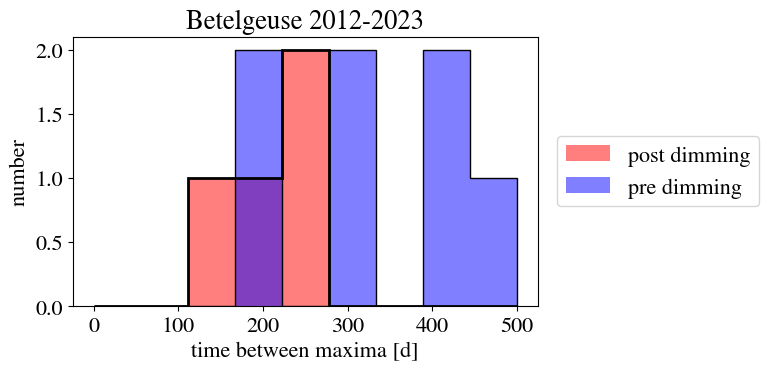

In [11]:
dt_rvminima = t_rvminima[1:]-t_rvminima[0:-1]
dt_rvminima_post = t_rvminima[t_rvminima>(2.4588e6-2.45e6)*u.d][1:]- t_rvminima[t_rvminima>(2.4588e6-2.45e6)*u.d][0:-1]
dt_rvminima_pre = t_rvminima[t_rvminima<(2.459e6-2.45e6)*u.d][1:]- t_rvminima[t_rvminima<(2.459e6-2.45e6)*u.d][0:-1]
print(dt_minima_post)
print(dt_minima_pre)

plt.figure(figsize=(6,3.5))
nbins = 10
#plt.hist(dt_minima.value,bins=np.linspace(0,500,nbins),color='0.7',label='all',rasterized=True)
plt.hist(dt_rvminima_post.value,bins=np.linspace(0,500,nbins),histtype='step',color="black",lw=2)
plt.hist(dt_rvminima_pre.value,bins=np.linspace(0,500,nbins),histtype='step',color="black")
plt.hist(dt_rvminima_post.value,bins=np.linspace(0,500,nbins),histtype='stepfilled',label='post dimming',alpha=0.5,color="red")
plt.hist(dt_rvminima_pre.value,bins=np.linspace(0,500,nbins),histtype='stepfilled',label='pre dimming',alpha=0.5,color="blue")
#plt.hist(dt_minima_post.value,bins=np.linspace(0,500,nbins),histtype='step',label='post dimming',alpha=0.7,lw=3,ls='--',hatch='/')
#plt.hist(dt_minima_pre.value,bins=np.linspace(0,500,nbins),histtype='step',label='pre dimming',alpha=0.7,lw=3,ls='--',hatch='\/')
plt.xlabel('time between maxima [d]')
plt.ylabel('number')
plt.legend(loc='center right',bbox_to_anchor=(1.5,0.5))
plt.title("Betelgeuse 2012-2023")

<Figure size 600x500 with 0 Axes>

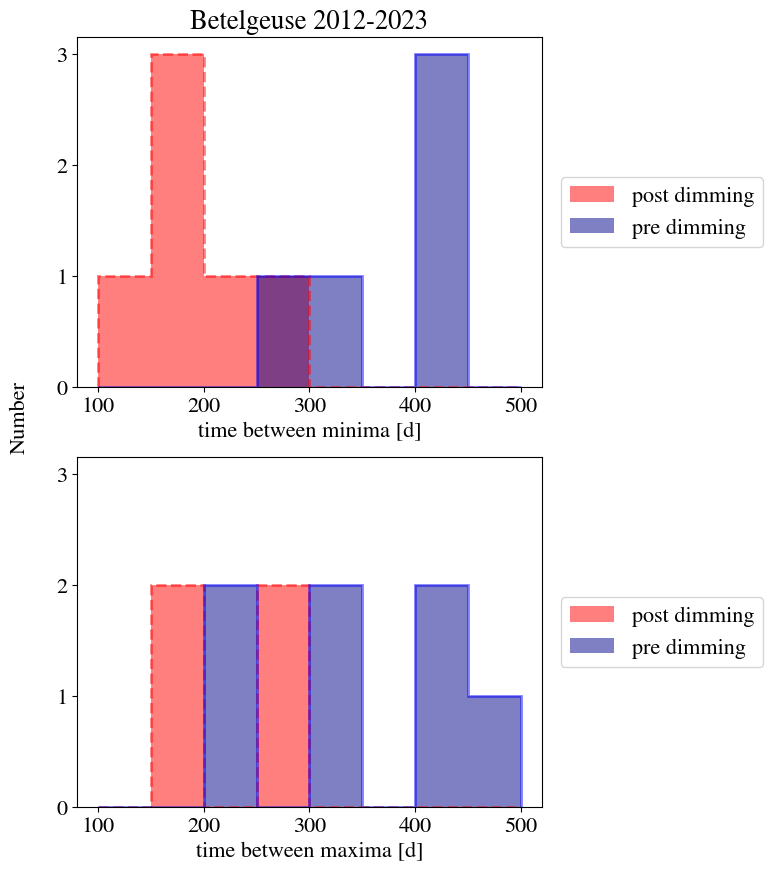

In [12]:
plt.clf()
fig, axs = plt.subplots(2, figsize=(6,10), sharey=True)
axs[0].set_title('Betelgeuse 2012-2023')
#ax = fig.add_subplot(111) 
#axs[0] = fig.add_subplot(211)
#axs[1] = fig.add_subplot(212)
nbins = 9
#plt.hist(dt_minima.value,bins=np.linspace(0,500,nbins),color='0.7',label='all',rasterized=True)
axs[0].hist(dt_minima_post.value,bins=np.linspace(100,500,nbins),histtype='step',color="Red",lw=2,ls='--',alpha=0.5)
axs[0].hist(dt_minima_pre.value,bins=np.linspace(100,500,nbins),histtype='step',color="Blue",lw=2,alpha=0.5)
axs[0].hist(dt_minima_post.value,bins=np.linspace(100,500,nbins),histtype='stepfilled',label='post dimming',alpha=0.5,color="red")
axs[0].hist(dt_minima_pre.value,bins=np.linspace(100,500,nbins),histtype='stepfilled',label='pre dimming',alpha=0.5,color="DarkBlue")
#plt.hist(dt_minima_post.value,bins=np.linspace(0,500,nbins),histtype='step',label='post dimming',alpha=0.7,lw=3,ls='--',hatch='/')
#plt.hist(dt_minima_pre.value,bins=np.linspace(0,500,nbins),histtype='step',label='pre dimming',alpha=0.7,lw=3,ls='--',hatch='\/')
axs[0].set_xlabel('time between minima [d]')
#axs[0].set_ylabel('Number')
axs[0].legend(loc='center right',bbox_to_anchor=(1.5,0.5))
axs[0].set_yticks([0,1,2,3])

#nbins = 10
#plt.hist(dt_minima.value,bins=np.linspace(0,500,nbins),color='0.7',label='all',rasterized=True)
axs[1].hist(dt_rvminima_post.value,bins=np.linspace(100,500,nbins),histtype='step',color="Red",lw=2,ls='--',alpha=0.5)
axs[1].hist(dt_rvminima_pre.value,bins=np.linspace(100,500,nbins),histtype='step',color="Blue",lw=2,alpha=0.5)
axs[1].hist(dt_rvminima_post.value,bins=np.linspace(100,500,nbins),histtype='stepfilled',label='post dimming',alpha=0.5,color="red")
axs[1].hist(dt_rvminima_pre.value,bins=np.linspace(100,500,nbins),histtype='stepfilled',label='pre dimming',alpha=0.5,color="DarkBlue")
#plt.hist(dt_minima_post.value,bins=np.linspace(0,500,nbins),histtype='step',label='post dimming',alpha=0.7,lw=3,ls='--',hatch='/')
#plt.hist(dt_minima_pre.value,bins=np.linspace(0,500,nbins),histtype='step',label='pre dimming',alpha=0.7,lw=3,ls='--',hatch='\/')
axs[1].set_xlabel('time between maxima [d]')
#axs[1].set_ylabel('Number')
axs[1].legend(loc='center right',bbox_to_anchor=(1.5,0.5))

fig.text(0.03, 0.5, 'Number', ha='center', va='center', rotation='vertical')
#plt.tight_layout()
plt.savefig('figs/Betelgeuse_hists.pdf',bbox_inches='tight')

In [9]:
dt_rvminima_pre

<Quantity [494.16742084, 324.10980638, 215.07286535, 200.06778172,
           417.14132488, 316.10709511, 417.14132488] d>

In [10]:
dt_rvminima_post

<Quantity [271.09184423, 156.05286974, 254.08608278, 177.05998682] d>

In [11]:
dt_minima_pre

<Quantity [501.25070008, 292.14611661, 428.21417093, 328.16413099,
           410.20516374, 418.20916693] d>

In [12]:
dt_minima_post

<Quantity [176.08807029, 111.05554433, 157.0785627 , 252.12610064,
           172.08606869, 227.11359065] d>